# Min distance objective

In [2]:
# import Pkg
# Pkg.add("Mosek")
# Pkg.build("Mosek")

In [216]:
# import Pkg
# Pkg.add("NLopt")
# Pkg.build("NLopt")

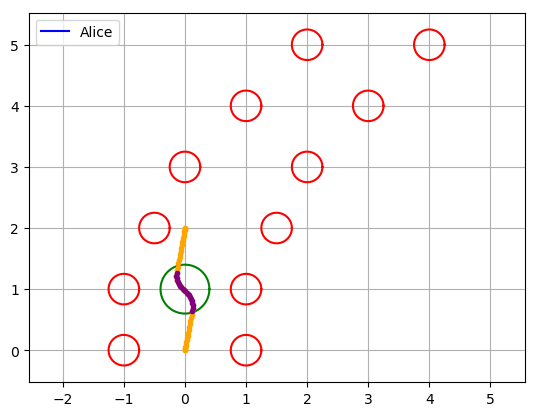

Optimal
d_tot_actual: 2.1081109728159992
Total energy: 12324.23222630368
Meeting location: (0.0, 2.0)


In [285]:
using JuMP, PyPlot, Ipopt, NLopt

# Define model, variables, constraints, objective
m = Model(solver=IpoptSolver(print_level=0))
#m = Model(solver=NLoptSolver(algorithm=:LD_MMA))

time = 60
start = [0, 0]
finish = [0, 2]

circles = [-1 0;
            1 0;
            -1 1;
            1 1
            1.5 2;
            -0.5 2;
            2 3;
            0 3;
            3 4;
            1 4;
            4 5;
            2 5]

r = 0.25

sand = [0 1]

r_sand = 0.4


num_sand, dim = size(sand)
num_circles, dim = size(circles)

@variable(m, x_A[1:2, 1:time])
@variable(m, v_A[1:2, 1:time])
@variable(m, u_A[1:2, 1:time])
#@variable(m, z[1:time], Bin)

# x index on east/west, y index on north/south
@constraint(m, x_A[:, 1] .== start) # Alice's initial position
@constraint(m, v_A[:, 1] .== [0, 0]) # Alice's initial velocity 

# Keep path away from obstacles defined by radii from circle center
for t in 1:time
    for c in 1:num_circles
    @NLconstraint(m, (x_A[1,t]-circles[c,1])^2 + (x_A[2,t]-circles[c,2])^2  >= (r+r/10)^2) 
    end
end

# make constraint for z=1 when going through sand
# m_lower = r_sand^2
# epsilon = 0.001
# for t in 1:time
#     for c in 1:num_sand
#     @NLconstraint(m, r_sand^2 - ((x_A[1,t]-sand[c,1])^2 + (x_A[2,t]-sand[c,2])^2 )  >= m_lower*z[t] + epsilon*(1-z[t])) 
#     end
# end

F_drag = 2
m_sand = -10000000
z = zeros(time)
start_sand = 20
end_sand = 40

for i in start_sand:end_sand
    z[i] = 1
end
F_drag = 20
mass = 10

for t in 1:time-1
    @constraint(m, u_A[:,t+1] - (u_A[:,t] + F_drag/mass) .>= m_sand*(1-z[t+1]) )
end



# Dynamic equations
timestep = 1/3600
for t in 1:time-1
     #@constraint(m, x_A[:, t+1] .== x_A[:, t] + timestep*v_A[:, t] + 0.5*u_A[:,t]*timestep^2) # Alice's position    
     #@constraint(m, v_A[:, t+1] .== v_A[:, t] + timestep*u_A[:, t]) # Alice's velocity
    
     @constraint(m, x_A[:, t+1] .== x_A[:, t] + timestep*v_A[:, t]) # Alice's position    
     @constraint(m, v_A[:, t+1] .== v_A[:, t] + u_A[:, t]) # Alice's velocity
end

@constraint(m, v_A[:,:] .<= 200)
@constraint(m, x_A[:, time] .== finish) # final location
@constraint(m, v_A[:, time] .== [0,0]) # final velocity

# Adds up euclidian distance between each time step
#d_tot = @NLexpression(m, sum{ (x_A[1,t+1]-x_A[1,t])^2 + (x_A[2,t+1]-x_A[2,t])^2, t=1:time-1}  ) 

#@NLobjective(m, Min, d_tot)
@objective(m, Min, sum(u_A.^2)) # minimize total energy

# Solve
status = solve(m)
println(status)
#optimize!(m)

d_tot_actual = 0
for t in 1:time-1
   d_tot_actual += sqrt( (getvalue(x_A[1,t+1])-getvalue(x_A[1,t]))^2 + (getvalue(x_A[2,t+1])-getvalue(x_A[2,t]))^2) 
end

u_tot_actual = 0
for t in 1:time-1
   u_tot_actual += sqrt( (getvalue(u_A[1,t+1])-getvalue(u_A[1,t]))^2 + (getvalue(u_A[2,t+1])-getvalue(u_A[2,t]))^2) 
end

#println("d_tot: ", getvalue(d_tot))
println("d_tot_actual: ", d_tot_actual)

# Printing all values for d_tot
# for t in 1:time-1
#     println(t," ",sqrt( (getvalue(x_A[1,t+1])-getvalue(x_A[1,t]))^2 + (getvalue(x_A[2,t+1])-getvalue(x_A[2,t]))^2 ))
# end

# Output
#x_A = JuMP.value.(x_A)
#println("Total energy: ", JuMP.objective_value(m))
x_A = getvalue(x_A)
println("Total energy: ", getvalue(sum(u_A.^2)))
println("Meeting location: (", x_A[1,time],", ",x_A[2,time],")")

# Graph path
plot(x_A[1, :], x_A[2, :], color="blue", label="Alice")
#plot(x_A[1, time_step], x_A[2, time_step], ".", color="orange")

# Plot circle
t = range(0,stop=2pi,length=100)         # parameter that traverses the circle
for c in 1:num_circles
    plot( circles[c,1] .+ r*cos.(t), circles[c,2] .+ r*sin.(t), color="red")  # plot circle radius r with center (x1, x2)
end

# Plot sand
t = range(0,stop=2pi,length=100)         # parameter that traverses the circle
for c in 1:num_sand
    plot( sand[c,1] .+ r_sand*cos.(t), sand[c,2] .+ r_sand*sin.(t), color="green")  # plot circle radius r with center (x1, x2)
end

# Plot time steps
for t in 1:time
   plot(x_A[1, t], x_A[2, t], ".", color="orange")
end

for t in start_sand:end_sand
    plot(x_A[1, t], x_A[2, t], ".", color="purple")
end


# Formatting
axis("equal")                            # make x and y scales equal
grid("on")
legend()
;

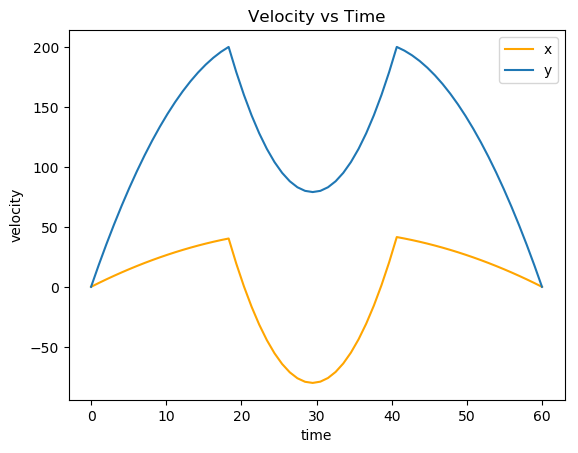

In [286]:
# Velocity plot
x = range(0, stop=time, length=time)
plot(x[:], getvalue(v_A)[1,:], label="x", color = "orange")
plot(x[:], getvalue(v_A)[2,:], label="y")
title("Velocity vs Time")
xlabel("time")
ylabel("velocity")
legend()
;

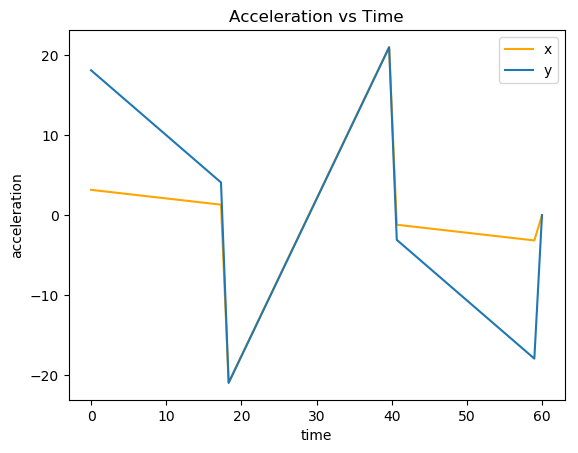

In [287]:
# Acceleration plot
x = range(0, stop=time, length=time)
plot(x[:], getvalue(u_A)[1,:], label="x", color = "orange" )
plot(x[:], getvalue(u_A)[2,:], label="y")

title("Acceleration vs Time")
xlabel("time")
ylabel("acceleration")
legend()
;

In [242]:
using JuMP
using NLopt

m = Model(solver=NLoptSolver(algorithm=:LD_MMA))

a1 = 2
b1 = 0
a2 = -1
b2 = 1

@variable(m, x1)
@variable(m, x2 >= 0)

@NLobjective(m, Min, sqrt(x2))
@NLconstraint(m, x2 >= (a1*x1+b1)^3)
@NLconstraint(m, x2 >= (a2*x1+b2)^3)

setvalue(x1, 1.234)
setvalue(x2, 5.678)

status = solve(m)

println("got ", getobjectivevalue(m), " at ", [getvalue(x1),getvalue(x2)])

got 0.5443310477213124 at [0.333333, 0.296296]


In [277]:
A = [0 0 0;
     0 1 0;
     0 0 0]

x = [1 1 1;
     1 0 0;
     1 0 0]

b = A*x
println(A.*x)

[0 0 0; 0 0 0; 0 0 0]
